In [2]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

# Define the autoencoder so pickle knows how to serialize it. 
# Later, we should actually save as a state_dict instead of a dumb pickle
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float32, l1_coef=0.0):
        super(AutoEncoder, self).__init__()
        
        # Only defining the decoder layer, encoder will share its weights
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=True)
        
        # Create a bias layer
        self.encoder_bias= nn.Parameter(torch.zeros(n_dict_components))
        
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        # Encoder is a Sequential with the ReLU activation
        # No need to define a Linear layer for the encoder as its weights are tied with the decoder
        self.encoder = nn.Sequential(nn.ReLU()).to(t_type)

        self.l1_coef = l1_coef
        self.activation_size = activation_size
        self.n_dict_components = n_dict_components

    def forward(self, x):
        c = self.encoder(x @ self.decoder.weight + self.encoder_bias)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        # Decoding step as before
        x_hat = self.decoder(c)
        return x_hat, c


    @property
    def device(self):
        return next(self.parameters()).device

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
filename = "ae4.pkl"
layer = 4
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = 0
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))
dict_index = 3
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]
print("smaller_dict.shape: ", smaller_dict.shape)
print("larger_dict.shape: ", larger_dict.shape)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
torch.Size([512, 512])
torch.Size([1024, 512])
torch.Size([2048, 512])
torch.Size([4096, 512])
torch.Size([8192, 512])
len of autoencoders:  1
smaller_dict.shape:  torch.Size([4096, 512])
larger_dict.shape:  torch.Size([8192, 512])


('# of features above 0.9:', 2717)


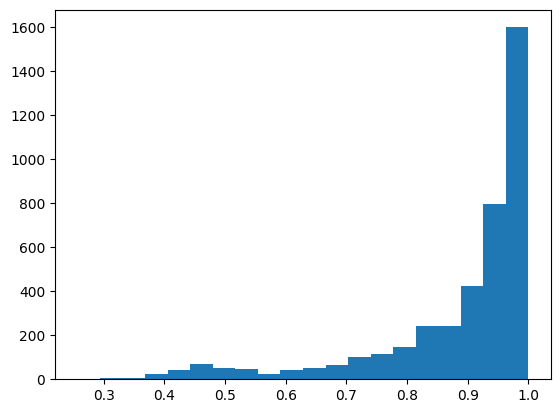

In [4]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
#Dictionary Comparison
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1].copy()
print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))
# Plot histogram of max_cosine_similarities
plt.hist(max_cosine_similarities, bins=20)
plt.show()

In [5]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 40
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-3d918a3b8bb67278.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-936b79d074ce1a9e.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5899fa893faa3f67.arrow


In [6]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 64
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

100%|██████████| 155/155 [00:04<00:00, 31.48it/s]


In [7]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = smaller_auto_encoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder, entire_feature_direction=False):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value
    
    def ablated_this_feature_dir(value, hook):
        value -= feature
        return value
    if(entire_feature_direction):
        return model.run_with_hooks(tokens, 
            fwd_hooks=[(
                cache_name, 
                ablated_this_feature_dir
                )]
            )
    else:
        return model.run_with_hooks(tokens, 
            fwd_hooks=[(
                cache_name, 
                mlp_ablation_hook
                )]
            )

def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False, entire_feature_direction=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder, entire_feature_direction).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


In [9]:
import re
import numpy as np

# Assuming you have a tokenizer like this (for example, from HuggingFace's tokenizers)
  # Replace with your tokenizer

def char_to_token_position(tokenized_output, char_idx):
    """
    Given a char-level index in the original string, find the corresponding token-level index.
    """
    token_positions = tokenized_output.char_to_token(char_idx)
    return token_positions

def find_text_in_regex(tokens, regex_pattern):
    """
    Find tokens inside parentheses and return token-level start and end indices.
    """
    detokenized_text = model.tokenizer.decode(tokens.input_ids)
    
    # Find matches in the detokenized text
    pattern = re.compile(regex_pattern)
    matches = pattern.finditer(detokenized_text)
    
    token_positions = []
    for match in matches:
        start_char, end_char = match.span()
        start_token = char_to_token_position(tokens, start_char)
        end_token = char_to_token_position(tokens, end_char)
        token_positions.append((start_token, end_token))
    return token_positions

# Sample data
texts = [
    "This is a sample (with something in parentheses) and",
    # ... more samples
]

# Inneficient way, but handles the token-to-string mapping
regex_pattern =  r'(?<=\().*?(?=\))'
texts = dataset["text"]
masks = []
extra_token_amount = 2 #For matching against the regex
for text_ind, text in enumerate(texts):
    tokens = model.tokenizer(text)
    # TODO: what if extra_token_amount finds text that's too large? Maybe go from large to small?
    tokens['input_ids'] = tokens['input_ids'][:token_amount + extra_token_amount]
    token_positions = find_text_in_regex(tokens, regex_pattern =regex_pattern)
    mask = np.zeros(token_amount, dtype=int)  # Initial mask
    for start, end in token_positions:
        if(end == None):
            print("No match found for text: ", model.tokenizer.decode(tokens.input_ids))
            print(start, end)
            continue
        if(end > token_amount):
            end = token_amount
        mask[start:end] = 1
    masks.append(mask)

No match found for text:  Batanes

Batanes (;, ) is an archipelagic province in the Philippines situated in the Cagayan Valley region. It is the northernmost province in the country, and also the smallest,
6 None


In [14]:
feature_index = 2079
regex_nonzero, feature_nonzero = np.array(masks).flatten().nonzero()[0], dictionary_activations[:, feature_index].numpy().nonzero()[0]
index_matches = np.intersect1d(regex_nonzero, feature_nonzero)
false_positives = np.setdiff1d(regex_nonzero, index_matches)
false_negatives = np.setdiff1d(feature_nonzero, index_matches)

# for reg_nz in regex_nonzero:
#     if(reg_nz in feature_nonzero):
#         print("Feature {} is activated by regex {}.".format(feature_index, reg_nz)
index_matches.shape, false_positives.shape, false_negatives.shape

((1991,), (8126,), (1090,))

In [16]:
found_indices = false_positives[:20]

datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
text_list = []
full_text = []
token_list = []
full_token_list = []
for md, s_ind in datapoint_indices:
    md = int(md)
    s_ind = int(s_ind)
    full_tok = torch.tensor(dataset[md]["input_ids"])
    full_text.append(model.tokenizer.decode(full_tok))
    tok = dataset[md]["input_ids"][:s_ind+1]
    text = model.tokenizer.decode(tok)
    text_list.append(text)
    token_list.append(tok)
    full_token_list.append(full_tok)
# text_list, full_text, token_list, full_token_list
visualize_text(text_list, feature_index, model)

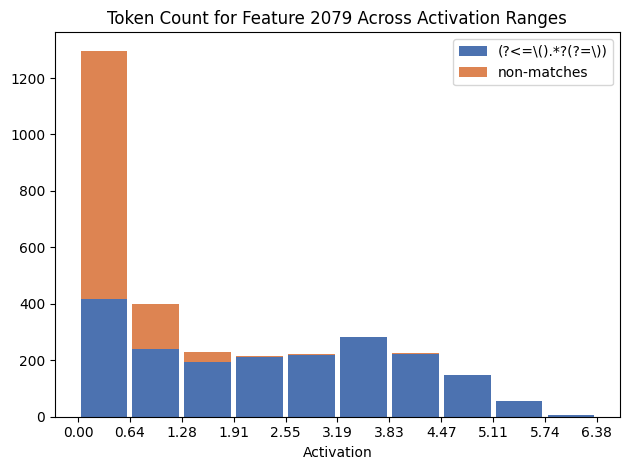

In [20]:
# 2079 2122 2118
feature_index = 2079
setting = "regex"
DEBUG=False
dictionary_activations = dictionary_activations
best_feature_activations = dictionary_activations[:, feature_index]
min_value = torch.min(best_feature_activations)
max_value = torch.max(best_feature_activations)

num_bins = 10
bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)
bins = torch.bucketize(best_feature_activations, bin_boundaries)

regex_matches_vs_nonmatches = np.zeros((num_bins, 2))
all_non_matched_tokens = []
non_matched_all_tokens = []
for i in range(1,num_bins+1):
    bin_non_matched_tokens = []
    bin_tokens_ind = (bins == i).nonzero()[:,0]
    # Grab the datapoint for each nonzero bin
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in bin_tokens_ind]
    max_token = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        regex_matches_vs_nonmatches[i-1, masks[md][s_ind]] += 1
        # Also count up instances of non-matches
        if(not masks[md][s_ind]):
            all_non_matched_tokens.append(dataset[md]["input_ids"][s_ind])
            bin_non_matched_tokens.append(dataset[md]["input_ids"][s_ind])
            non_matched_all_tokens.append(dataset[md]["input_ids"][:s_ind+1])
        max_token.append(dataset[md]["input_ids"][s_ind])
    if(DEBUG):
        ac = Counter(bin_non_matched_tokens)
        print(f'\nBin {i}')
        for token_ind, count in ac.most_common(10):
            print(f'{model.tokenizer.decode(token_ind)}: {count:6} times')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

colors = sns.color_palette('deep', num_unique_tokens + 1)  # +1 for the 'Misc' bar

data = regex_matches_vs_nonmatches
num_bins, num_unique_tokens = data.shape

# Set position of bars
barWidth = (bin_boundaries[1] - bin_boundaries[0]) * 0.9
r = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
running_sum = np.zeros(num_bins)
for i in range(data.shape[1]):
    if i == 0:
        text_label = regex_pattern
    else:
        text_label = "non-matches"
    token_count_array = data[:,(i+1)%2]
    plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)  # Stack on top of data1+data2
    running_sum += token_count_array
# plt.bar(r, misc_count, bottom=running_sum,  label='Misc', color=colors[-1])  # Stack on top of data1+data2
plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
plt.xlabel('Activation')
# plt.xticks(r, [f"{val:.1f}" for val in bin_boundaries[:]])
plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])
plt.legend()
plt.tight_layout()
plt.show()

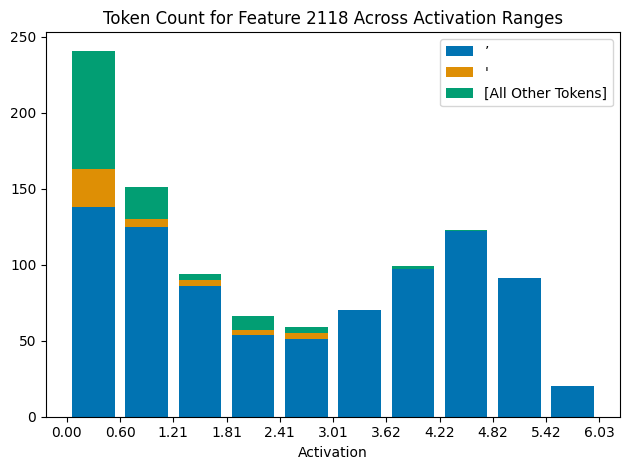

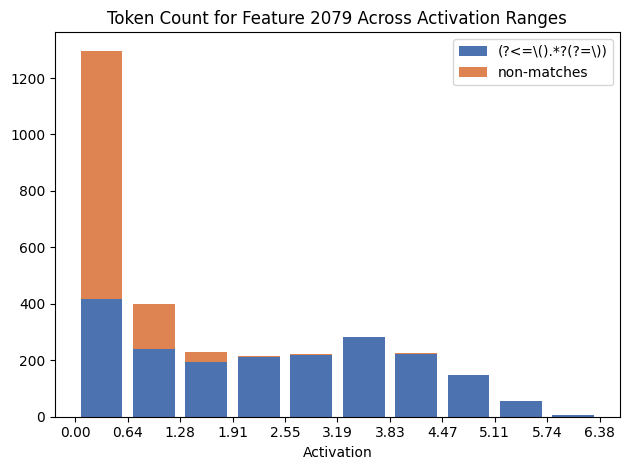

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def prepare_data(dictionary_activations, feature_index, num_bins=10):
    best_feature_activations = dictionary_activations[:, feature_index]
    min_value = torch.min(best_feature_activations)
    max_value = torch.max(best_feature_activations)
    bin_boundaries = torch.linspace(min_value, max_value, num_bins+1)
    bins = torch.bucketize(best_feature_activations, bin_boundaries)
    return best_feature_activations, bin_boundaries, bins

def compute_bar_positions(bin_boundaries):
    barWidth = (bin_boundaries[1] - bin_boundaries[0]) * 0.8
    r = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    return r, barWidth

def process_data_type1(bins, dataset, num_bins, num_unique_tokens, model):
    nonzero = bins.nonzero()[:,0]
    datapoint_indices = [np.unravel_index(i, (datapoints, token_amount)) for i in nonzero]
    max_token = [dataset[int(md)]["input_ids"][int(s_ind)] for md, s_ind in datapoint_indices]
    
    ac = Counter(max_token)
    max_tokens = [token_ind for token_ind, count in ac.most_common(num_unique_tokens)]
    token_dict = {token: np.zeros(num_bins) for token in max_tokens}
    misc_count = np.zeros(num_bins)

    for i in range(1, num_bins+1):
        bin_tokens_ind = (bins == i).nonzero()[:,0]
        datapoint_indices = [np.unravel_index(ind, (datapoints, token_amount)) for ind in bin_tokens_ind]
        max_token = [dataset[int(md)]["input_ids"][int(s_ind)] for md, s_ind in datapoint_indices]
        ac = Counter(max_token)
        for token_ind, count in ac.most_common(10):
            if token_ind in max_tokens:
                token_dict[token_ind][i-1] = count
            else:
                misc_count[i-1] += count

    return token_dict, misc_count, max_tokens

def process_data_type2(bins, dataset, num_bins, masks, regex_pattern):
    regex_matches_vs_nonmatches = np.zeros((num_bins, 2))
    all_non_matched_tokens = []
    non_matched_all_tokens = []
    for i in range(1,num_bins+1):
        bin_tokens_ind = (bins == i).nonzero()[:,0]
        datapoint_indices = [np.unravel_index(i, (datapoints, token_amount)) for i in bin_tokens_ind]
        for md, s_ind in datapoint_indices:
            md = int(md)
            s_ind = int(s_ind)
            regex_matches_vs_nonmatches[i-1, masks[md][s_ind]] += 1
            if not masks[md][s_ind]:
                all_non_matched_tokens.append(dataset[md]["input_ids"][s_ind])
                non_matched_all_tokens.append(dataset[md]["input_ids"][:s_ind+1])
    return regex_matches_vs_nonmatches, all_non_matched_tokens

def plot_data_type1(r, barWidth, bin_boundaries, data, model):
    token_dict, misc_count, max_tokens = data
    colors = sns.color_palette('colorblind', len(max_tokens) + 1)
    running_sum = np.zeros(len(bin_boundaries) - 1)
    for i in range(len(max_tokens)):
        token_id_name = max_tokens[i]
        token_count_array = token_dict[token_id_name]
        text_label = model.tokenizer.decode(token_id_name)
        plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)
        running_sum += token_count_array
    plt.bar(r, misc_count, bottom=running_sum, label='[All Other Tokens]', color=colors[-1], width=barWidth)
    plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
    plt.xlabel('Activation')
    plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_data_type2(r, barWidth, bin_boundaries, data, regex_pattern):
    regex_matches_vs_nonmatches, all_non_matched_tokens = data
    colors = sns.color_palette('deep', regex_matches_vs_nonmatches.shape[1] + 1)
    running_sum = np.zeros(len(bin_boundaries) - 1)
    for i in range(regex_matches_vs_nonmatches.shape[1]):
        text_label = regex_pattern if i == 0 else "non-matches"
        token_count_array = regex_matches_vs_nonmatches[:, (i+1)%2]
        plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)
        running_sum += token_count_array
    plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
    plt.xlabel('Activation')
    plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:

# For the first type:
feature_index = 2118
activations, bin_boundaries, bins = prepare_data(dictionary_activations, feature_index)
r, barWidth = compute_bar_positions(bin_boundaries)
data1 = process_data_type1(bins, dataset, num_bins, num_unique_tokens, model)
plot_data_type1(r, barWidth, bin_boundaries, data1, model)

# For the second type:
feature_index = 2079
activations, bin_boundaries, bins = prepare_data(dictionary_activations, feature_index)
r, barWidth = compute_bar_positions(bin_boundaries)
data2 = process_data_type2(bins, dataset, num_bins, masks, regex_pattern)
plot_data_type2(r, barWidth, bin_boundaries, data2, regex_pattern)



Bin 1
 (:    245 times
.:    127 times

:    111 times
-:     20 times


:      8 times
H:      6 times
SC:      5 times
G:      5 times
ER:      5 times
DR:      5 times

Bin 2
 (:     83 times
.:     10 times

:      4 times
P:      2 times
UC:      2 times
QS:      2 times
ī:      2 times
LA:      2 times
aban:      2 times
II:      1 times

Bin 3

:     10 times
 (:      5 times
C:      2 times
 DS:      1 times
G:      1 times
IL:      1 times
10:      1 times
 rate:      1 times
PC:      1 times
S:      1 times

Bin 4
ERT:      1 times
 IC:      1 times
Q:      1 times
-:      1 times
F:      1 times

Bin 5
PR:      1 times
DA:      1 times
I:      1 times
CRT:      1 times

Bin 6
PE:      1 times
AC:      1 times

Bin 7
2:      1 times
F:      1 times
WM:      1 times

Bin 8
MT:      1 times

Bin 9

Bin 10


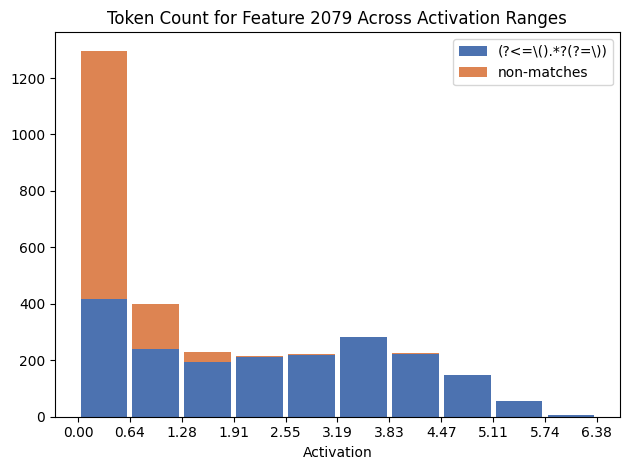

In [18]:
# 2079 2122 2118
feature_index = 2079
dictionary_activations = dictionary_activations
best_feature_activations = dictionary_activations[:, feature_index]

min_value = torch.min(best_feature_activations)
max_value = torch.max(best_feature_activations)

# Define the number of bins
num_bins = 10

# Calculate the bin boundaries as linear interpolation between min and max
bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

# Assign each activation to its respective bin
bins = torch.bucketize(best_feature_activations, bin_boundaries)

regex_matches_vs_nonmatches = np.zeros((num_bins, 2))
all_non_matched_tokens = []
non_matched_all_tokens = []
for i in range(1,num_bins+1):
    bin_non_matched_tokens = []
    bin_tokens_ind = (bins == i).nonzero()[:,0]
    # Grab the datapoint for each nonzero bin
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in bin_tokens_ind]
    max_token = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        regex_matches_vs_nonmatches[i-1, masks[md][s_ind]] += 1
        # Also count up instances of non-matches
        if(not masks[md][s_ind]):
            all_non_matched_tokens.append(dataset[md]["input_ids"][s_ind])
            bin_non_matched_tokens.append(dataset[md]["input_ids"][s_ind])
            non_matched_all_tokens.append(dataset[md]["input_ids"][:s_ind+1])
        max_token.append(dataset[md]["input_ids"][s_ind])
    ac = Counter(bin_non_matched_tokens)
    print(f'\nBin {i}')
    for token_ind, count in ac.most_common(10):
        print(f'{model.tokenizer.decode(token_ind)}: {count:6} times')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

colors = sns.color_palette('deep', num_unique_tokens + 1)  # +1 for the 'Misc' bar

setting = "regex"
data = regex_matches_vs_nonmatches
num_bins, num_unique_tokens = data.shape

# # Set position of bars
# r = np.arange(num_bins)

# Set position of bars
barWidth = (bin_boundaries[1] - bin_boundaries[0]) * 0.9
# r = np.arange(num_bins)
r = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
running_sum = np.zeros(num_bins)
for i in range(num_unique_tokens):
    if i == 0:
        text_label = regex_pattern
    else:
        text_label = "non-matches"
    token_count_array = data[:,(i+1)%2]
    plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)  # Stack on top of data1+data2
    running_sum += token_count_array
# plt.bar(r, misc_count, bottom=running_sum,  label='Misc', color=colors[-1])  # Stack on top of data1+data2
plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
plt.xlabel('Activation')
# plt.xticks(r, [f"{val:.1f}" for val in bin_boundaries[:]])
plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])
plt.legend()
plt.tight_layout()
plt.show()

In [173]:
# non_matched_all_tokens[:3]
formatted_tokens = [torch.tensor([token]) for token in non_matched_all_tokens]
visualize_text(formatted_tokens[:20], feature_index, model)

In [128]:
non_matched_all_tokens[:3]
formatted_tokens = [torch.tensor([token]) for token in non_matched_all_tokens]
formatted_tokens[:3]

[tensor([[46167,    27,  9838,  2254, 21811, 33584,   187,   187]]),
 tensor([[38941, 37757,  6915,   322,   461,  1243, 40626,   313,  4899, 17423,
           2262,   416,  1050,    70,   285,  2332,  2216,    15,   187, 18497,
             74, 11033,  2728,   313,    36]]),
 tensor([[26788,   434,   403,  1620,   794,  1051, 16829,   672,   352,   434,
           4255,  5516,  1165,     7,    34]])]

In [33]:
regex_matches_vs_nonmatches.shape

(10, 2)

In [110]:
bin_boundaries[1],  bin_boundaries[0]

(tensor(0.6383), tensor(0.))

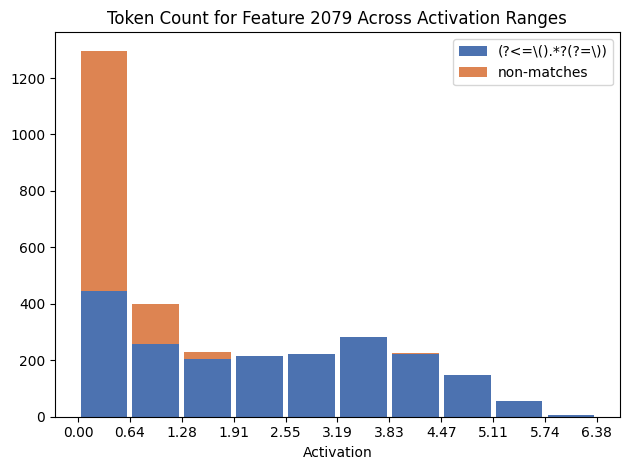

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

colors = sns.color_palette('deep', num_unique_tokens + 1)  # +1 for the 'Misc' bar

setting = "regex"
data = regex_matches_vs_nonmatches
num_bins, num_unique_tokens = data.shape

# # Set position of bars
# r = np.arange(num_bins)

# Set position of bars
barWidth = (bin_boundaries[1] - bin_boundaries[0]) * 0.9
# r = np.arange(num_bins)
r = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
running_sum = np.zeros(num_bins)
for i in range(num_unique_tokens):
    if i == 0:
        text_label = regex_pattern
    else:
        text_label = "non-matches"
    token_count_array = data[:,(i+1)%2]
    plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)  # Stack on top of data1+data2
    running_sum += token_count_array
# plt.bar(r, misc_count, bottom=running_sum,  label='Misc', color=colors[-1])  # Stack on top of data1+data2
plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
plt.xlabel('Activation')
# plt.xticks(r, [f"{val:.1f}" for val in bin_boundaries[:]])
plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])
plt.legend()
plt.tight_layout()
plt.show()
# Include non-zero+
# PCA/ICA baselines

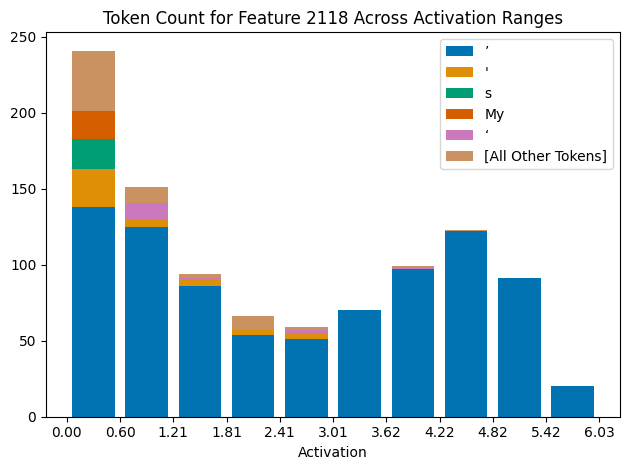

In [17]:
# 2079 2122 2118
feature_index = 2118
best_feature_activations = dictionary_activations[:, feature_index]

min_value = torch.min(best_feature_activations)
max_value = torch.max(best_feature_activations)

# Define the number of bins
num_bins = 10

DEBUG = False
# Calculate the bin boundaries as linear interpolation between min and max
bin_boundaries = torch.linspace(min_value, max_value, num_bins+1)
# Assign each activation to its respective bin
bins = torch.bucketize(best_feature_activations, bin_boundaries)
# Count the number of unique tokens

num_unique_tokens = 5
from collections import Counter
nonzero = bins.nonzero()[:,0]
datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in nonzero]
max_token = []
for md, s_ind in datapoint_indices:
    md = int(md)
    s_ind = int(s_ind)
    max_token.append(dataset[md]["input_ids"][s_ind])

ac = Counter(max_token)
max_tokens = [token_ind for token_ind, count in ac.most_common(num_unique_tokens)]
token_dict = {token: np.zeros(num_bins) for token in max_tokens}
misc_count = np.zeros(num_bins)
for i in range(1,num_bins+1):
    bin_tokens_ind = (bins == i).nonzero()[:,0]
    # Grab the datapoint for each nonzero bin
    datapoint_indices =[np.unravel_index(ind, (datapoints, token_amount)) for ind in bin_tokens_ind]
    max_token = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        max_token.append(dataset[md]["input_ids"][s_ind])
    ac = Counter(max_token)
    for token_ind, count in ac.most_common(10):
        if(token_ind in max_tokens):
            token_dict[token_ind][i-1] = count
        else:
            misc_count[i-1] += count
        if(DEBUG):
            print(f'{model.tokenizer.decode(token_ind)}: {count:6} times')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# This line gets a palette of colors. 'deep' is just one of many palettes available.
colors = sns.color_palette('colorblind', num_unique_tokens + 1)  # +1 for the 'Misc' bar

# Set position of bars
barWidth = (bin_boundaries[1] - bin_boundaries[0]) * 0.8
# r = np.arange(num_bins)
r = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
running_sum = np.zeros(num_bins)
for i in range(num_unique_tokens):
    token_id_name = max_tokens[i]
    token_count_array = token_dict[token_id_name]
    text_label = model.tokenizer.decode(token_id_name)
    plt.bar(r, token_count_array, bottom=running_sum, label=text_label, color=colors[i], width=barWidth)
    running_sum += token_count_array
plt.bar(r, misc_count, bottom=running_sum,  label='[All Other Tokens]', color=colors[-1], width=barWidth)  # Stack on top of data1+data2
plt.title(f'Token Count for Feature {feature_index} Across Activation Ranges')
plt.xlabel('Activation')
# plt.xticks(r, [f"{val:.1f}" for val in bin_boundaries])
plt.xticks(bin_boundaries, [f"{val:.2f}" for val in bin_boundaries])

plt.legend()
plt.tight_layout()
plt.show()
# Include non-zero+
# PCA/ICA baselines

In [32]:
# t = " Bratwurst, Sauerkraut, und Bier"
# t = "我们一起去玩吧"
# t = "for i in range"
t = " I don't know about Dave'"
# t = " I like to eat them (apples and oranges"
# t = " I like to eat them at National Institute of Justice (NIJ"
t = "いさんさん��に"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

Activations: [2.71, 2.58, 2.32, 1.45, 1.39, 1.38, 1.15, 0.93, 0.42, 0.19]
Feature_ids [3119, 2118, 3920, 3608, 3146, 50, 1978, 2016, 3190, 3025]


In [120]:
N = 101
best_feature = int(max_indices[N])
# best_feature = 2122 #Mandarin
# best_feature = 2118 # 's
best_feature = 2079 # (within parentheses)

# best_feature = 2917 # open paran before acronym
# best_feature = 2808 # open paran before acronym
# best_feature = 2808 # (within parentheses)
# best_feature = 3482 # 3482, 4072, 3920, 310
print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# visualize_text(full_text, best_feature, model)
visualize_text(text_list, best_feature, model)

bias: -2.6281512
Feature index: 2079
MCS: 0.9694181084632874


In [118]:
ablate_text(text_list, best_feature, model)

In [31]:
ablate_feature_direction_display(full_text, best_feature)

In [32]:
logit_lens(model,best_feature, smaller_dict, layer)

['stadt', 'heim', 'sson', 'reich', ' GmbH', 'ös', 'hof', 'haus', ' Germany', 'enburg', 'mann', 'heimer', 'äs', 'ungs', 'furt', 'feld', ' von', 'hardt', 'sche', ' Munich']
tensor([2.4493, 2.3906, 2.3506, 2.2867, 2.2223, 2.2117, 2.1515, 2.1397, 2.1175,
        2.1167, 2.0961, 2.0806, 2.0570, 2.0537, 2.0246, 2.0191, 2.0135, 2.0103,
        2.0070, 2.0050])
